In [1]:
#basic setup for python 3 - includes all required imports
import numpy as np
import pandas as pd
import os
np.random.seed(42)#to make this notebook's output identical at every run

%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge, ElasticNet
import seaborn as sns

import tarfile #for opening tar-files (similar to zip)
import urllib #for online data imports

In [2]:
#get data online via link (data is safed as tarfile -> different procedure for zip folders)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

#define function to fetch data - then execute function
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

#load data and give a preview (".head" = first five rows of csv-sheet)
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
#would otherwise load whole csv-sheet
housing = load_housing_data()
housing.head()

#use "housing.info()" or "housing.describe()" to get background information about data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
#here we see that the table has 10 colums with different variables and 
#20640 lines with data points for each variable
#for total_bedrooms data is missing -> gap needs to be filled later
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


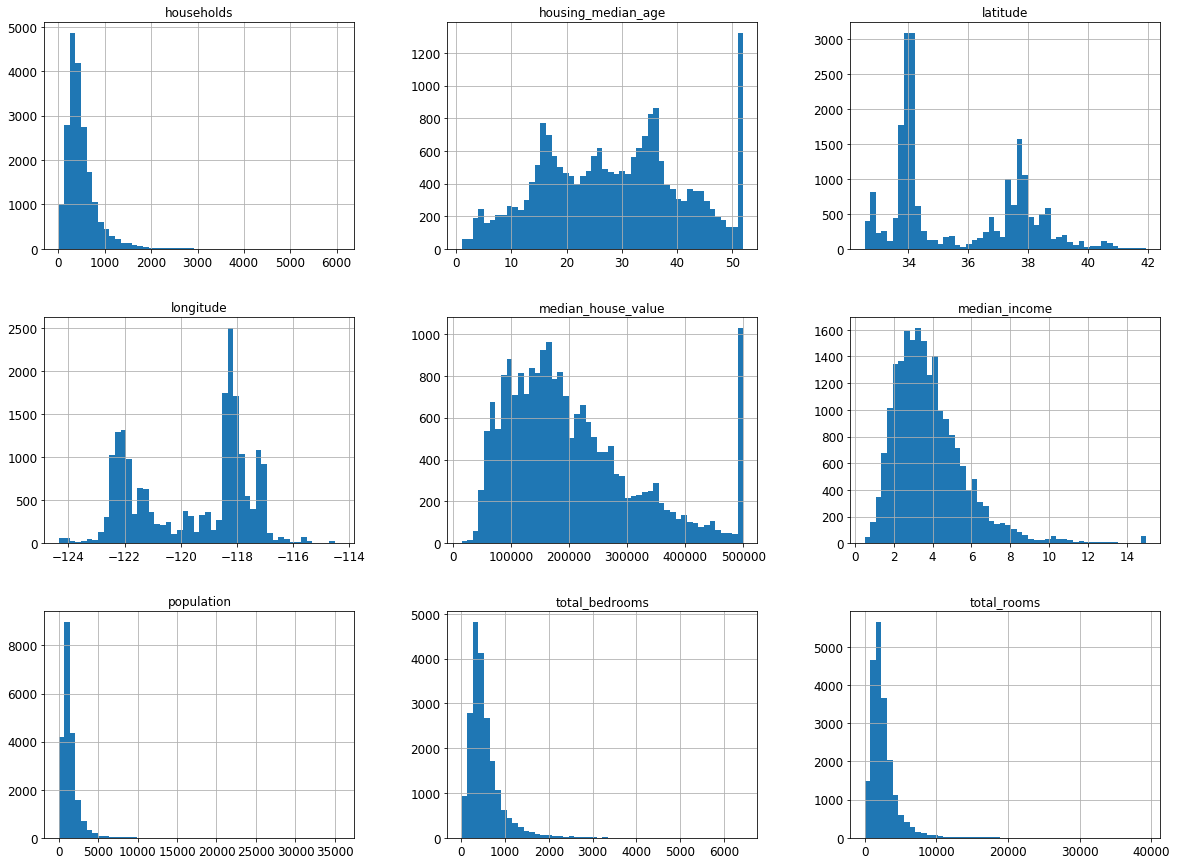

In [4]:
#show data to get better understanding (uses matplot) 
#gives many error messages but shows diagrams at end - previous code ensures, diagrams are being saved
#maybe find function that ignores error messages

housing.hist(bins=50, figsize=(20,15))
plt.show()

#remarks about data: scales are obviously not normalized, 
#also for housing_median_age, median_house_value and median_income the data is "capped",
#meaning that all values larger than a certain value were combined together 

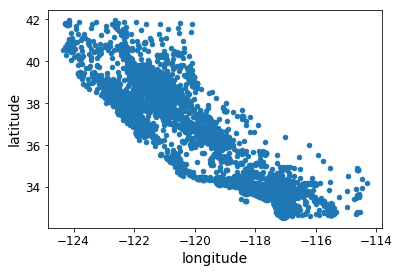

In [5]:
housing.plot(kind="scatter", x="longitude", y="latitude") #"longitude" and "latitude" are the variables in the csv file that shall be depicted
plt.show()

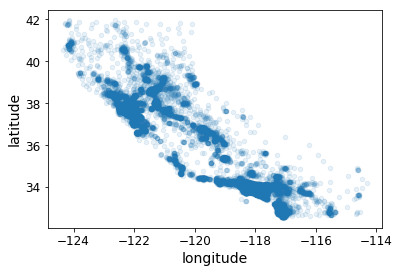

In [6]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1) #alpha is density of data points -> shall be reduced a bit for better visualization
plt.show()

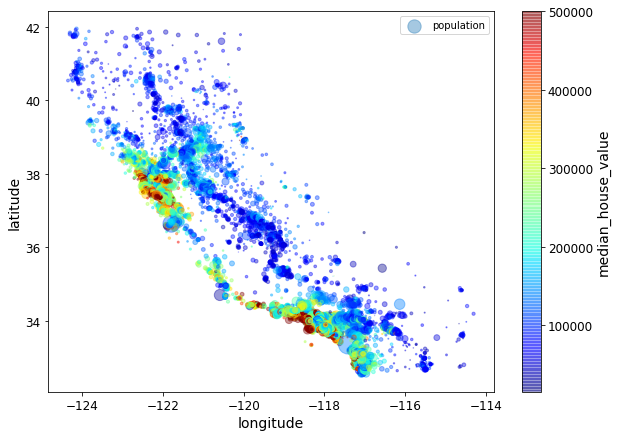

In [7]:
#shows the higly dense living areas with high house values (in northern and southern Cali close to coasline)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7), #s = size of color-circles
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, #c = color of color-circles, colorbar shall be shown
    sharex=False) #separate x-axis shall be shown
plt.legend()
plt.show()

In [8]:
#modify data set according with goal to predict house values
y = housing['median_house_value'] #this shall be predicted (dependent/predicted variable)
x = housing.drop('median_house_value', axis = 1) #therefore, it has to be removed from independend/predictive variables

#as shown before, total_bedrooms missed data points -> fill gap with median
x['total_bedrooms'].fillna(x.total_bedrooms.median(), inplace = True)

In [9]:
#create three new collumns (that make more sense )
x['rooms_per_house'] = x['total_rooms']/x['households']
x['bedrooms_per_room'] = x['total_bedrooms']/x['total_rooms']
x['population_per_household'] = x['population']/x['households']

#split dataset
#train_test_split is a predefined function from sklearn splitting the set in 75% train and 25% test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

size_training_set = len(x_train)
print("Length training-set:", size_training_set)

size_test_set = len(x_test)
print("Length test-set:", size_test_set)

Length training-set: 15480
Length test-set: 5160


In [10]:
#shows correlation between median_house_value and others variables to indicate best predictive power of the variables
train = x_train.join(y_train)
corr_mat = train.corr()
corr_mat['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688697
rooms_per_house             0.156825
total_rooms                 0.133474
housing_median_age          0.103291
households                  0.063463
total_bedrooms              0.048612
population_per_household   -0.021422
population                 -0.025960
longitude                  -0.047271
latitude                   -0.142351
bedrooms_per_room          -0.252021
Name: median_house_value, dtype: float64

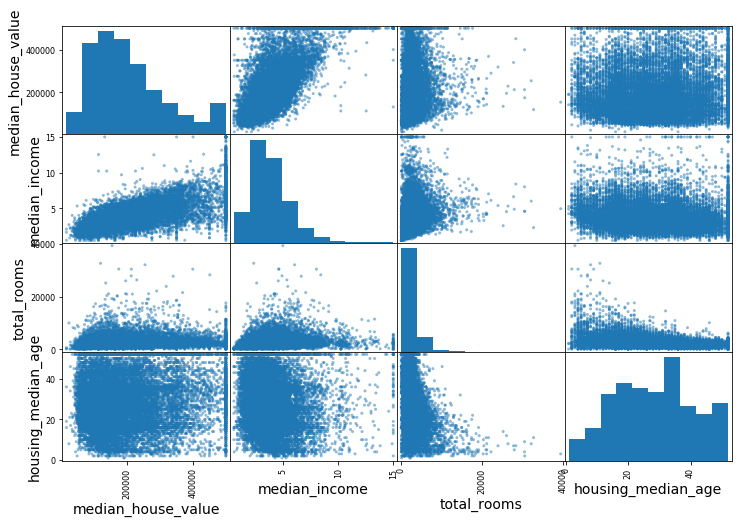

In [11]:
#visualize the most important correlations between median_house_value and
#median_income, rooms_per_house, total_rooms and housing_median_age
from pandas.plotting import scatter_matrix

housing_corr = train[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']]
scatter_matrix(housing_corr, figsize=(12,8))
plt.show()

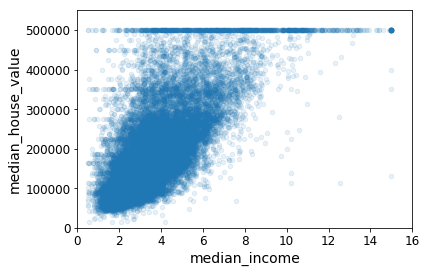

In [12]:
#since median_income showed best correlation here a closer look
#shows again how data is capped
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

In [13]:
#create linear regression model and scaling data
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
x = train['median_income'].values.reshape(-1,1)
y = train['median_house_value']
lm.fit(x,y)
predict = lm.predict(x)

#calculate mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predict, y)
np.sqrt(mse)

#result is not sufficiently good as housing prices are in 6-figure range

83752.33902656472

In [14]:
#try to improve model by taking more variables into account
#have to transform object data (ocean_proximity) first -> using dummy variables
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 8158 to 15795
Data columns (total 13 columns):
longitude                   15480 non-null float64
latitude                    15480 non-null float64
housing_median_age          15480 non-null float64
total_rooms                 15480 non-null float64
total_bedrooms              15480 non-null float64
population                  15480 non-null float64
households                  15480 non-null float64
median_income               15480 non-null float64
ocean_proximity             15480 non-null object
rooms_per_house             15480 non-null float64
bedrooms_per_room           15480 non-null float64
population_per_household    15480 non-null float64
median_house_value          15480 non-null float64
dtypes: float64(12), object(1)
memory usage: 2.3+ MB


In [15]:
dummies = pd.get_dummies(train['ocean_proximity'])

In [16]:
train = train.join(dummies)

In [17]:
train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'rooms_per_house', 'bedrooms_per_room',
       'population_per_household', 'median_house_value', '<1H OCEAN', 'INLAND',
       'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

In [18]:
train = train.drop('<1H OCEAN', axis = 1)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 8158 to 15795
Data columns (total 17 columns):
longitude                   15480 non-null float64
latitude                    15480 non-null float64
housing_median_age          15480 non-null float64
total_rooms                 15480 non-null float64
total_bedrooms              15480 non-null float64
population                  15480 non-null float64
households                  15480 non-null float64
median_income               15480 non-null float64
ocean_proximity             15480 non-null object
rooms_per_house             15480 non-null float64
bedrooms_per_room           15480 non-null float64
population_per_household    15480 non-null float64
median_house_value          15480 non-null float64
INLAND                      15480 non-null uint8
ISLAND                      15480 non-null uint8
NEAR BAY                    15480 non-null uint8
NEAR OCEAN                  15480 non-null uint8
dtypes: float64(12), object(1)

In [20]:
train = train.drop('ocean_proximity', axis = 1)
train.info()
#ocean_proximity has been replaces

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 8158 to 15795
Data columns (total 16 columns):
longitude                   15480 non-null float64
latitude                    15480 non-null float64
housing_median_age          15480 non-null float64
total_rooms                 15480 non-null float64
total_bedrooms              15480 non-null float64
population                  15480 non-null float64
households                  15480 non-null float64
median_income               15480 non-null float64
rooms_per_house             15480 non-null float64
bedrooms_per_room           15480 non-null float64
population_per_household    15480 non-null float64
median_house_value          15480 non-null float64
INLAND                      15480 non-null uint8
ISLAND                      15480 non-null uint8
NEAR BAY                    15480 non-null uint8
NEAR OCEAN                  15480 non-null uint8
dtypes: float64(12), uint8(4)
memory usage: 2.2 MB


In [38]:
y = train['median_house_value']
x = train.drop('median_house_value', axis = 1)

In [45]:
#scaling
#use a polynomial model to see if it works better as linear regression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('std_scaler', StandardScaler()), ('poly_features', PolynomialFeatures(degree = 4))])
housing_prepared = pipeline.fit_transform(x)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [46]:
#model
lm = LinearRegression()
lm.fit(housing_prepared, y)
lm.score(housing_prepared, y)
lm.predict(housing_prepared[:10])

array([253482.6687476 , 346768.17357701, 248919.34419221, 407745.23611516,
       118124.04511517, 213238.52989453, 315243.35906476,  92032.77678937,
       504528.29104489, 109688.6778304 ])

In [48]:
predictions = lm.predict(housing_prepared)
mse = mean_squared_error(predictions, y)
np.sqrt(mse)
#better result with polynomial model!
#the higher the degree of the polynomial the better the result - but also the longer the calc. time!
#also danger of overfitting! (compare MSE for training set and test set)
#degree 2: MSE = 59389.09795917648
#degree 3: MSE = 51346.009038598575
#degree 4: MSE = 43914.803448984305
#degree 5: MSE = 32087.82384948893

43914.803448984305

In [49]:
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
alphas = [0.5,1,4,10,50,100]
param_grid = [{'alpha':alphas}]

grid_search = GridSearchCV(lasso, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search.fit(housing_prepared, y)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the n

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': [0.5, 1, 4, 10, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [50]:
grid_search.best_estimator_
lasso.fit(housing_prepared, y)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [51]:
predictions = lasso.predict(housing_prepared)
mse = mean_squared_error(predictions,y)
np.sqrt(mse)

49262.305984285835

In [52]:
#evaluate on test set
x_test['total_bedrooms'].fillna(x_test.total_bedrooms.median(), inplace = True)

dummies = pd.get_dummies(x_test['ocean_proximity'])
x_test = x_test.join(dummies)
x_test = x_test.drop('ocean_proximity', axis = 1)
y = y_test

In [53]:
scaler = StandardScaler()
x = scaler.fit_transform(x_test)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [54]:
lasso.fit(x,y)
predictions = lasso.predict(x)
mse = mean_squared_error(predictions, y)
np.sqrt(mse)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


68566.69926062935